In [7]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

dataset, info = tfds.load('uc_merced', with_info=True)

print(info)

train_percentage = 0.7
test_percentage = 0.3

num_examples = info.splits['train'].num_examples
num_train_examples = int(train_percentage * num_examples)

train_dataset = dataset['train'].take(num_train_examples)
test_dataset = dataset['train'].skip(num_train_examples)

# Preprocess the dataset
def preprocess_data(example):
    image = tf.image.resize(example['image'], (224, 224))
    image = tf.cast(image, tf.float32) / 255.0  
    label = example['label']
    return image, label

train_dataset = train_dataset.map(preprocess_data)
test_dataset = test_dataset.map(preprocess_data)


# Define CNN model
model = keras.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5), 
    layers.Dense(21, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


tfds.core.DatasetInfo(
    name='uc_merced',
    full_name='uc_merced/2.0.0',
    description="""
    UC Merced is a 21 class land use remote sensing image dataset, with 100 images
    per class. The images were manually extracted from large images from the USGS
    National Map Urban Area Imagery collection for various urban areas around the
    country. The pixel resolution of this public domain imagery is 0.3 m.
    
    While most images are 256x256 pixels, there are 44 images with different shape.
    """,
    homepage='http://weegee.vision.ucmerced.edu/datasets/landuse.html',
    data_dir='/Users/vivianwang/tensorflow_datasets/uc_merced/2.0.0',
    file_format=tfrecord,
    download_size=317.07 MiB,
    dataset_size=238.63 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=21),
    }),
    supervised_keys=('image', 'label'),
  

In [8]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 111, 111, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 128)     73856     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 54, 54, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 52, 52, 256)       295168    
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 26, 26, 256)      

In [9]:
batch_size = 32
epochs = 50 

# Add Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Define data augmentation settings
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_images = []
train_labels = []
for image, label in train_dataset:
    train_images.append(image.numpy())
    train_labels.append(label.numpy())

train_images = np.array(train_images)
train_labels = np.array(train_labels)

datagen.fit(train_images)  
history = model.fit(datagen.flow(train_images, train_labels, batch_size=batch_size),
                    epochs=epochs,
                    validation_data=test_dataset.batch(batch_size),
                    callbacks=[early_stopping])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_dataset.batch(batch_size))
print(f'Test accuracy: {test_accuracy}')

2023-10-22 00:05:53.608645: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 1/50
46/46 [==============================] - 268s 6s/step - loss: 3.3685 - accuracy: 0.0571 - val_loss: 3.0125 - val_accuracy: 0.0317
Epoch 2/50
46/46 [==============================] - 309s 7s/step - loss: 2.9734 - accuracy: 0.0707 - val_loss: 2.9454 - val_accuracy: 0.0571
Epoch 3/50
46/46 [==============================] - 271s 6s/step - loss: 2.8896 - accuracy: 0.1061 - val_loss: 2.8810 - val_accuracy: 0.0778
Epoch 4/50
46/46 [==============================] - 276s 6s/step - loss: 2.8108 - accuracy: 0.1068 - val_loss: 2.7670 - val_accuracy: 0.1413
Epoch 5/50
46/46 [==============================] - 266s 6s/step - loss: 2.7554 - accuracy: 0.1245 - val_loss: 2.6644 - val_accuracy: 0.1841
Epoch 6/50
46/46 [==============================] - 268s 6s/step - loss: 2.5640 - accuracy: 0.1762 - val_loss: 2.3270 - val_accuracy: 0.2429
Epoch 7/50
46/46 [==============================] - 330s 7s/step - loss: 2.4047 - accuracy: 0.2054 - val_loss: 2.2717 - val_accuracy: 0.2762
Epoch 8/50
46

In [21]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_dataset.batch(batch_size))
print(f'Test accuracy: {test_accuracy}')

20/20 [==============================] - 61s 3s/step - loss: 0.7613 - accuracy: 0.7397
Test accuracy: 0.7396825551986694


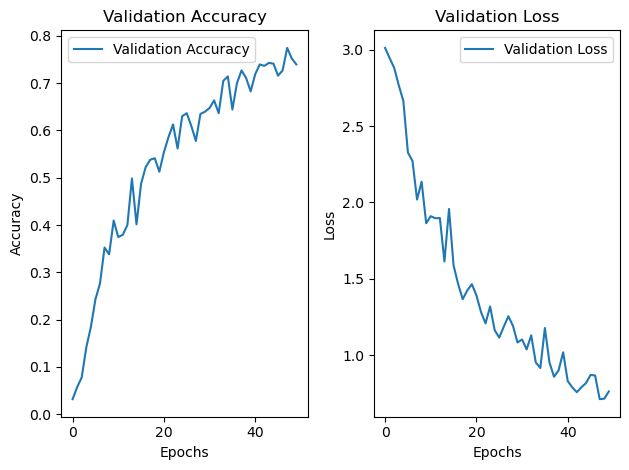

In [25]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Plot validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')

# Plot validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Validation Loss')

plt.tight_layout()
plt.show()


From the plot, I observed a significant overfitting problem. To further enhance my model in the future, I will:
1. Construct a more complex model by adding additional layers or using a larger training dataset.
2. Generate a confusion matrix to identify specific misclassifications.

1/1 [==============================] - 0s 96ms/step


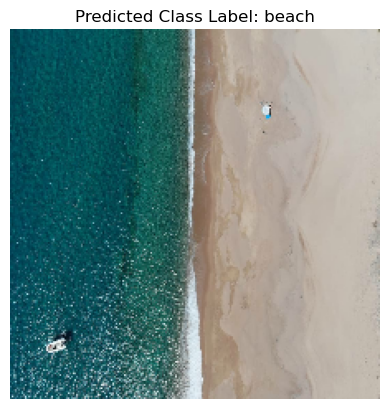

In [46]:
import numpy as np

random_image_path = '/Users/vivianwang/Desktop/6289 midterm/sample image/image 1.jpeg' 
random_image = tf.io.read_file(random_image_path)
random_image = tf.image.decode_image(random_image)
random_image = tf.image.resize(random_image, (224, 224))
random_image = random_image / 255.0  

random_image = tf.expand_dims(random_image, 0)


predicted_class_index = np.argmax(model.predict(random_image))
class_mapping = info.features['label'].int2str  # Get class labels
predicted_class_label = class_mapping(predicted_class_index)

import matplotlib.pyplot as plt 

plt.imshow(random_image[0])
plt.title(f'Predicted Class Label: {predicted_class_label}')
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 106ms/step


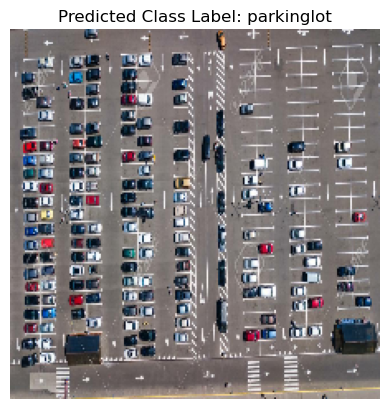

In [47]:
import numpy as np

random_image_path = '/Users/vivianwang/Desktop/6289 midterm/sample image/image 2.jpeg' 
random_image = tf.io.read_file(random_image_path)
random_image = tf.image.decode_image(random_image)
random_image = tf.image.resize(random_image, (224, 224))
random_image = random_image / 255.0  

random_image = tf.expand_dims(random_image, 0)

predicted_class_index = np.argmax(model.predict(random_image))
class_mapping = info.features['label'].int2str  # Get class labels
predicted_class_label = class_mapping(predicted_class_index)

import matplotlib.pyplot as plt 

plt.imshow(random_image[0])
plt.title(f'Predicted Class Label: {predicted_class_label}')
plt.axis('off')
plt.show()

@InProceedings{Nilsback08,
   author = "Yang, Yi and Newsam, Shawn",
   title = "Bag-Of-Visual-Words and Spatial Extensions for Land-Use Classification",
   booktitle = "ACM SIGSPATIAL International Conference on Advances in Geographic Information Systems (ACM GIS)",
   year = "2010",
}